In [105]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [31]:
#reading the file
full_data = pd.read_excel("Recorded Data.xlsx")
print(pd.read_excel("Recorded Data.xlsx"))

        Nozzle Test Data      Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0   Barometric pressure:  29.35 in of Hg         NaN         NaN         NaN   
1               Test no:               1         2.0        3.00        4.00   
2         Back pressure:               0        30.0       40.00       50.00   
3        Inlet temp (C):              25        25.5       25.00       25.00   
4       Outlet temp (C):              20        19.5       22.50       22.50   
5               Orifice:            3.03         3.1        2.98        3.02   
6                      1              85        87.0       86.00       86.00   
7                      2              86        87.0       86.00       86.00   
8                      3              86        87.0       86.00       86.00   
9                      4              86        87.0       86.00       86.00   
10                     5              86        87.0       85.00       86.00   
11                     6              85

In [11]:
#reading and importing data from excel file, only displaying columns B-J (Test 1 - 9) and only rows starting with static pressures
raw_data = pd.read_excel("Recorded Data.xlsx", usecols="B:J", skiprows=6)
#print(raw_data)

## Task 1a

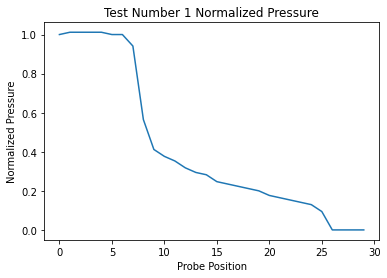

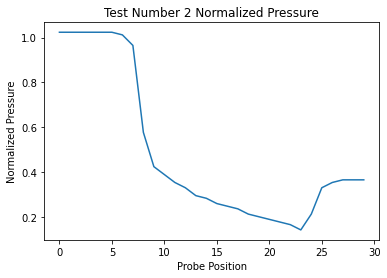

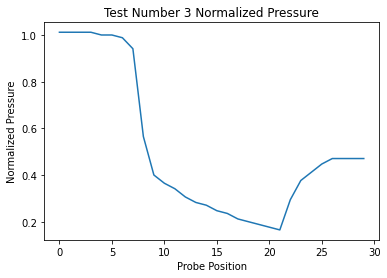

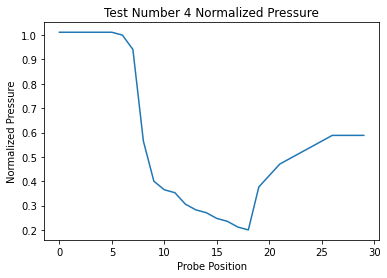

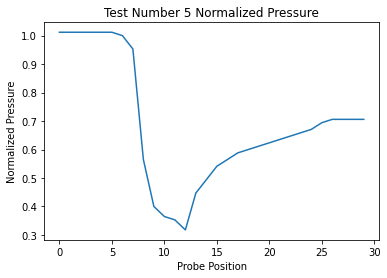

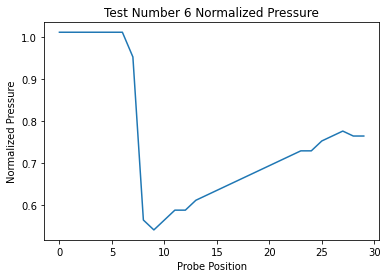

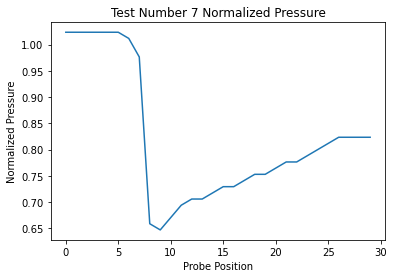

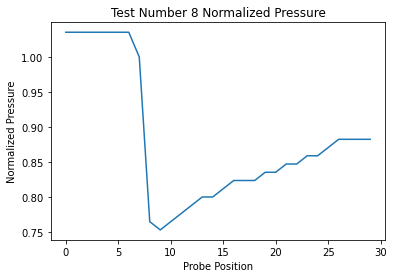

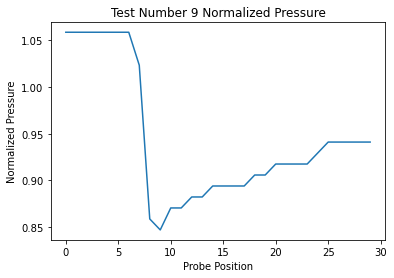

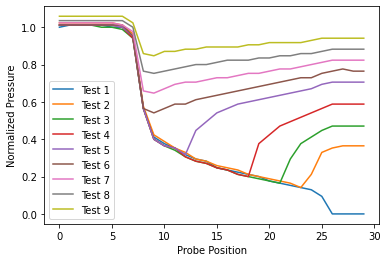

In [59]:
#constants
p_t = 85 #psig given in the lab report

#creating list for normalized pressures
p_norm_data = np.zeros((len(raw_data), 9))

#calculating the normalized pressure profile
for i in range(9):
    for j in range(len(raw_data)):
        p_norm = raw_data.iloc[j,i]/p_t
        p_norm_data[j, i] = p_norm

#plotting the data
for i in range(9):
    x = np.arange(0, 30, 1)
    y = p_norm_data[:,i]
    plt.plot(x,y)
    plt.title("Test Number {} Normalized Pressure".format(i+1))
    plt.ylabel("Normalized Pressure")
    plt.xlabel("Probe Position")
    plt.show()

#plotting all the data together
x = np.arange(0, 30, 1)
y = p_norm_data[:,:]
plt.plot(x,y)
plt.ylabel("Normalized Pressure")
plt.xlabel("Probe Position")
plt.legend(["Test 1", "Test 2", "Test 3", "Test 4", "Test 5", "Test 6", "Test 7", "Test 8", "Test 9"])
plt.show()

## Task 1b

In [ ]:
#constants
back_pressures = [0, 30, 40, 50, 60, 65, 70, 75, 80]
x = np.arange(0, 30, 1)

#finding the exit pressures for each test (at position 26)
exit_pressures = []
for i in range(9):
    exit_pressures.append(raw_data.iloc[25,i])
print(exit_pressures)

#creating the arrays for the data
p_e_norm_data = np.zeros((len(raw_data), 9))
p_b_norm_data = np.zeros((len(raw_data), 9))

#normalized exit pressures (pe/p0)
for i in range(9):
    for j in range(len(raw_data)):
        p_e_norm = exit_pressures[i]/raw_data.iloc[j,i]
        p_e_norm_data[j, i] = p_e_norm

#normalized back pressures (pb/p0)
for i in range(9):
    for j in range(len(raw_data)):
        p_b_norm = back_pressures[i]/raw_data.iloc[j,i]
        p_b_norm_data[j, i] = p_b_norm

#plotting the data
for i in range(9):
    x = p_e_norm_data[:,i]
    y = p_b_norm_data[:,i]
    plt.plot(x,y)
    plt.title("Test Number {}: Normalized Exit Pressure vs Normalied Back Pressure".format(i+1))
    plt.ylabel("Normalized Back Pressure")
    plt.xlabel("Normalized Exit Pressure")
    plt.show()

## Task 1c

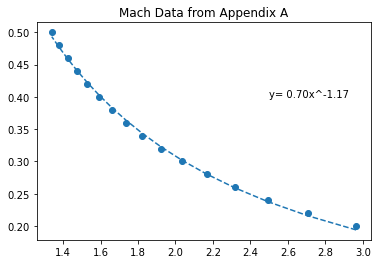

[1, 1, 1, 0.5034400884362649, 0.4679803834898613, 0.4350132376511386, 0.38910645505124414, 0.3264869389612989, 0.21589671535807253]


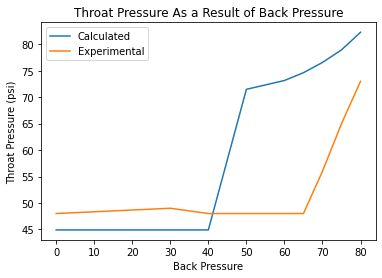

In [136]:
#constants
gamma = 1.4
A_exit = np.pi*(0.2869/2)**2 #area of the nozzle at the exit, in^2
A_throat = np.pi*(0.2504/2)**2 #area of the throat, in^2
A_ratio = A_exit/A_throat #area ratio

#determining critical back pressure 
p_crit = p_t * (2/(gamma+1))**(gamma/(gamma-1)) #critical back pressure for supersonic flow

#determining which tests were supersonic
A_t_ratio = []
p_throat_calc = []
M_throat_vals = []

for i in range(9):
    if full_data.iloc[2, i+1] >= p_crit: #back pressures greater than p_crit are not sonic
        p_e = exit_pressures[i] #getting the experimental exit pressure
        M_e = np.sqrt((2/(gamma-1))*(np.power(p_t/p_e, (1/(gamma/(gamma-1)))) - 1)) #finding mach @ exit
        A_ratio_critical = (1/M_e) * ((2/(gamma+1)) * (1 + (gamma-1)/2 * M_e**2))**((gamma+1)/(2*(gamma-1))) #finding exit critical ratio (Ae/A*)
        #("Test {} is not sonic, with an exit Mach of {:.2f} \n Critical Area Ratio is: {}".format(i+1, M_e, A_ratio_critical))
        A_ratio_tstar = A_ratio*A_ratio_critical #gives the ratio of area throat over critical area At/A*
        #print("Throat Area Ratio (At/A*) for test {}: {:.3f}".format(i+1, A_ratio_tstar))
        A_t_ratio.append(A_ratio_tstar)

    else:
        p_throat_sonic = 85*(1 + (gamma-1)/2 * 1**2)**(-gamma / (gamma-1)) #if p_b > p_crit mach @ throat = 1
        #print("Test {} is sonic at throat, therefore the throat pressure is: {:.2f} psi".format(i+1, p_throat_sonic))
        p_throat_calc.append(p_throat_sonic)
        M_throat_vals.append(1)

#with the area ratios printed, using John D. Anderson's "Fundamentals of Aerodynamics" the Mach number for the calculated area
#can be determined. Appendix A holds the charts (only the subsonic value for the given A/A*).
M_ref = [0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5]
A_ratio_ref = [2.964, 2.708, 2.496, 2.317, 2.166, 2.035, 1.922, 1.823, 1.736, 1.659, 1.59, 1.529, 1.474, 1.425, 1.38, 1.34]

#want to do a power line of best fit
def f(x, a, b):
    return a*x**b

#finding the line of best fit
popt, pcov = curve_fit(f, A_ratio_ref, M_ref)
a = popt[0]
b = popt[1]

#plotting the data and line of best fit to verify good fit
plt.scatter(A_ratio_ref, M_ref)
plt.plot(A_ratio_ref, f(A_ratio_ref, *popt), '--')
plt.text(2.5, 0.4, "y= {:.2f}x^{:.2f}".format(a, b))
plt.title("Mach Data from Appendix A")
plt.show()

#finding throat Mach then pressure at throat with the best fit values
for i in range(len(A_t_ratio)):
    M_t = a*A_t_ratio[i]**b
    p_throat = 85*(1 + (gamma-1)/2 * M_t**2)**(-gamma / (gamma-1))
    p_throat_calc.append(p_throat)
    M_throat_vals.append(M_t)
    

p_throat_experiment = []
for i in range(9): #throat position is at 9
    p_throat_e = full_data.iloc[14, i+1]
    p_throat_experiment.append(p_throat_e)

print(M_throat_vals)

plt.plot(back_pressures, p_throat_calc) #plotting the calculated throat pressure
plt.plot(back_pressures, p_throat_experiment) #plotting experimental data
plt.xlabel("Back Pressure")
plt.ylabel("Throat Pressure (psi)")
plt.title("Throat Pressure As a Result of Back Pressure")
plt.legend(["Calculated", "Experimental"])


## Task 1d

[0.08040746115113617, 0.08133095694032441, 0.07974127352266308, 0.08027466591410029, 0.08054003743432539, 0.08080453744824394, 0.07866363921029641, 0.07361933558766669, 0.06597662854993758]


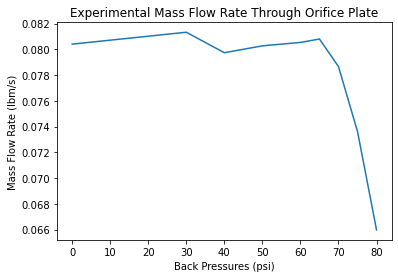

In [137]:
#constants
d_orifice = 1.625 #in
D_pipe = 3.1875 #in
A_th = np.pi*(d_orifice/2)**2 / 144 #ft^2
g_c = 32.174 #(lbm-ft)/(lbf-s^2)
F_a = 1.0 
C_D = 0.623
Beta = d_orifice/D_pipe
R = 10.731 #psi⋅ft^3⋅lbmol^−1⋅°R^−1
rho_f = 0.0739 #lbm/ft^3

#calcualting rho using the equation p = rho*R*T, with p being at the throat which equals position 9
# p_throat_data = [] #psig
# for i in range(9):
#     p_throat_data.append(raw_data.iloc[8,i])

# T_recorded = []
# for i in range(9):
#     T_in = full_data.iloc[3,i+1] #getting the inlet recorded temp.
#     T_in = T_in*(9/5)+491.67 #converting from Celsius to Rankine
#     T_recorded.append(T_in)

# rho_f = [] #lbm/ft^3
# for i in range(9):
#     rho = p_throat_data[i]/(R*T_recorded[i]) * 28.966 #going from lbmol to lbm (lbm/ft^3)
#     rho_f.append(rho)
# #print(rho_f)

#getting delta p
delta_p = []
for i in range(9):
    p_diff = full_data.iloc[5,i+1] #in of H20
    p_diff = p_diff*5.197 #lbf/ft^2
    delta_p.append(p_diff)

#calculating m_dot
m_dot_data = []
for i in range(9):
    m_dot = A_th * F_a * (C_D / np.sqrt(1 - Beta**4)) * np.sqrt(2*g_c*rho_f*delta_p[i])
    m_dot_data.append(m_dot)

print(m_dot_data) #lbm/s

#plotting
x = np.arange(0, 9, 1)
plt.plot(back_pressures, m_dot_data)
plt.title("Experimental Mass Flow Rate Through Orifice Plate")
plt.xlabel("Back Pressures (psi)")
plt.ylabel("Mass Flow Rate (lbm/s)")
plt.show()


## Task 1e

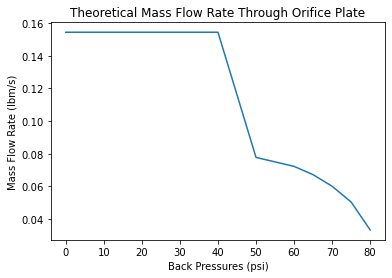

In [152]:
#for an ideal compressible gas the equation 
T = 25*9/5+491.67 #C to Rankine
R = 49711 #ft^2*s^-2*°R^−1, completing the unit conversion from the units from 1d

a = np.sqrt(gamma*R*T)

m_dot_theory_values = []
for i in range(9):
    v = M_throat_vals[i]*a
    m_dot_theory =  rho_f*v*(A_throat/144) #getting area of the throat into ft^2
    m_dot_theory_values.append(m_dot_theory)

plt.plot(back_pressures, m_dot_theory_values)
plt.title("Theoretical Mass Flow Rate Through Orifice Plate")
plt.xlabel("Back Pressures (psi)")
plt.ylabel("Mass Flow Rate (lbm/s)")
plt.show()


## Task 2

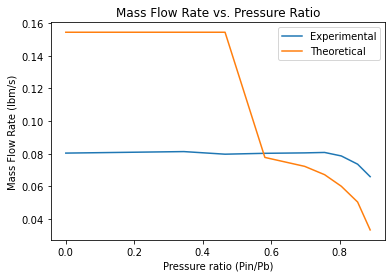

In [154]:
#calculating pressure ratio
p_ratio = []
for i in range(9):
    p_ratio.append(back_pressures[i]/full_data.iloc[6,i+1])

#plotting data
plt.plot(p_ratio, m_dot_data)
plt.plot(p_ratio, m_dot_theory_values)
plt.xlabel("Pressure ratio (Pin/Pb)")
plt.ylabel("Mass Flow Rate (lbm/s)")
plt.title("Mass Flow Rate vs. Pressure Ratio")
plt.legend(["Experimental", "Theoretical"])
plt.show()

## Task 3